<a href="https://colab.research.google.com/github/wcjb/Deep-learn/blob/master/%E5%A4%9A%E5%8F%98%E9%87%8F%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 数据清理

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format = 'svg'

df2018 = pd.read_excel('Downloads/安顺-增加天气.xlsx',sheet_name=0)
df2017 = pd.read_excel('Downloads/安顺-增加天气.xlsx',sheet_name=1)
df = df2017.append(df2018,sort = True)

In [51]:
# 查看内存占用情况
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 364
Data columns (total 11 columns):
99家       365 non-null object
地区        694 non-null object
天气        730 non-null object
店名        730 non-null object
日期        730 non-null datetime64[ns]
日期.1      730 non-null object
最低气温      730 non-null object
最高气温      730 non-null object
现金总实洋     730 non-null float64
空气质量指数    730 non-null object
风向风力      730 non-null object
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 580.4 KB


In [0]:
# 删除不需要使用的列
del df['99家'],df['地区'],df['日期'],df['店名']

In [53]:
df.head()

,天气,日期.1,最低气温,最高气温,现金总实洋,空气质量指数,风向风力
0,多云,2017-01-01星期日,8℃,12℃,15893.167925,73良,无持续风向微风
1,阴,2017-01-02星期一,8℃,13℃,12418.788720,83良,南风1-2级
2,阵雨~小雨,2017-01-03星期二,10℃,13℃,4178.724000,89良,无持续风向微风
3,小雨~阴,2017-01-04星期三,11℃,15℃,6622.540662,25优,无持续风向微风
4,多云~阴,2017-01-05星期四,11℃,16℃,4986.050000,24优,西南风1-2级


In [0]:

# 重新设置df的columns顺序
df = df.reindex(columns=['日期.1','天气','最低气温','最高气温','空气质量指数','风向风力','现金总实洋'])
df.index = range(df.shape[0])

现在需要将天气、日期等特征进行量化，以便于进一步提取有效特征。

In [0]:
# 提前分配好内存空间存放量化后的特征
data = pd.DataFrame(np.zeros(df.shape),columns=['日期','天气','最低气温','最高气温','空气质量指数','风向风力','现金总实洋'])
datedict = {'一':1,'二':2,'三':3,'四':4,'五':5,'六':6,'日':7}

In [90]:
import re
data.现金总实洋 = df.现金总实洋
for i in tqdm(df.index):
    data.at[i,'天气'] = df['天气'].value_counts()[df.at[i,'天气']]
    data.at[i,'日期'] = datedict[df.at[i,'日期.1'][-1]]
    data.at[i,'最低气温'] = df.at[i,'最低气温'][:-1]
    data.at[i,'最高气温'] = df.at[i,'最高气温'][:-1]
    data.at[i,'空气质量指数'] = int(re.findall('\d+',df.at[i,'空气质量指数'])[0])
    data.at[i,'风向风力'] = df['风向风力'].value_counts()[df.at[i,'风向风力']]
    

100%|██████████| 730/730 [00:01<00:00, 586.59it/s]


In [92]:
data.head()

,日期,天气,最低气温,最高气温,空气质量指数,风向风力,现金总实洋
0,7.0,82.0,8.0,12.0,73.0,349.0,15893.167925
1,1.0,76.0,8.0,13.0,83.0,155.0,12418.788720
2,2.0,9.0,10.0,13.0,89.0,349.0,4178.724000
3,3.0,19.0,11.0,15.0,25.0,349.0,6622.540662
4,4.0,88.0,11.0,16.0,24.0,2.0,4986.050000


In [0]:
# 对数据集进行0-1标准化
time = data.copy()
for i in time.columns:
    time[i] = (data[i]-data[i].mean())/data[i].std()

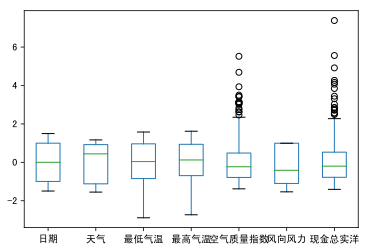

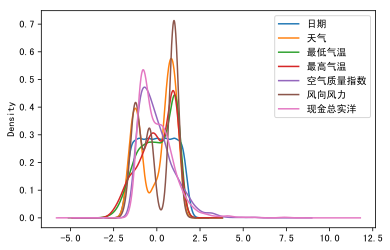

In [111]:
time.plot(kind='box')
time.plot(kind='kde')

In [151]:
# Loss回归进行特征选筛选
from sklearn.linear_model import RidgeCV

linear = RidgeCV(fit_intercept=True,cv=2)
linear.fit(time[time.columns[:-1]].values,time[time.columns[-1]].values)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=2, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [144]:
linear.coef_

array([ 0.46497743,  0.02028535,  0.09698217, -0.09297959, -0.01453391,
        0.12213607])

In [173]:
from sklearn.linear_model import RandomizedLogisticRegression as RLR

rlr = RLR()
rlr.fit(time[time.columns[:-1]].values,[round(i) for i in time[time.columns[-1]].values
])

RandomizedLogisticRegression(C=1, fit_intercept=True, memory=None,
               n_jobs=None, n_resampling=200, normalize=True,
               pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [174]:
rlr.all_scores_

array([[1.   ],
       [0.   ],
       [0.005],
       [0.005],
       [0.   ],
       [0.01 ]])

In [164]:
rlr.get_support()

array([ True, False, False, False, False, False])

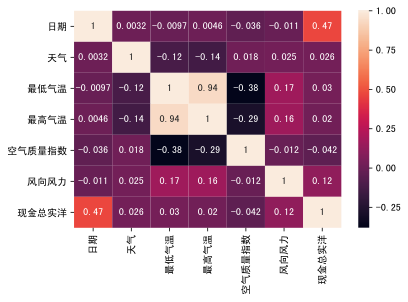

In [176]:
import seaborn as sns
sns.heatmap(time.corr(),annot=True)

In [178]:
import IPython.core.display as di 
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)